<a href="https://colab.research.google.com/github/dev-marcos/LSTM-Time-Series-Analysis-of-Cryptocurrency-Prices/blob/main/Previsao_preco_BITCOIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregando os dados

Fonte dos dados: https://finance.yahoo.com/quote/BTC-USD/history?period1=1638417600&period2=1670039999&interval=1d&frequency=1d&filter=history

In [46]:
import pandas as pd
import numpy as np

In [47]:
df_btc_usd = pd.read_csv('BTC-USD.csv')
df_btc_usd['Date'] = pd.to_datetime(df_btc_usd['Date'])
df_btc_usd = df_btc_usd.sort_values(by=['Date'], ascending=True) 

In [48]:
df_btc_usd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
values = df_btc_usd['Close'].values.reshape( -1 ,1)

In [5]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['font.size'] = 22

(array([735234., 735599., 735964., 736330., 736695., 737060., 737425.,
        737791., 738156., 738521.]),
 <a list of 10 Text major ticklabel objects>)

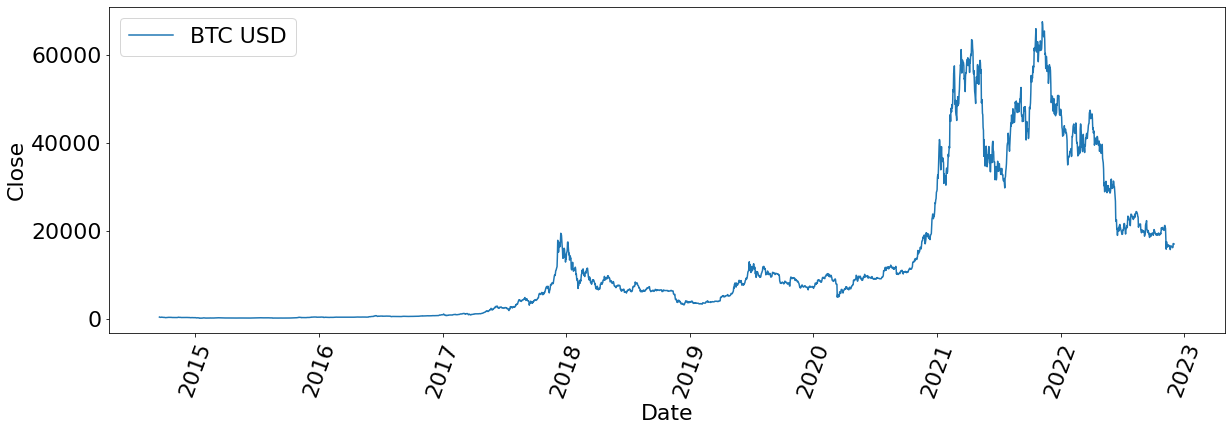

In [51]:
sns.lineplot(x='Date',y='Close', data=df_btc_usd, label='BTC USD') 
#plt.yscale('log')
plt.xticks(rotation=70)

#Dividindo em treino e teste

In [19]:
train_size = int(len(df_btc_usd) * 0.95)
test_size = len(df_btc_usd) - train_size

In [20]:
train , test = scaled_data[0: train_size] , scaled_data[ train_size :len(df_btc_usd) ,:]

(array([735234., 735599., 735964., 736330., 736695., 737060., 737425.,
        737791., 738156., 738521.]),
 <a list of 10 Text major ticklabel objects>)

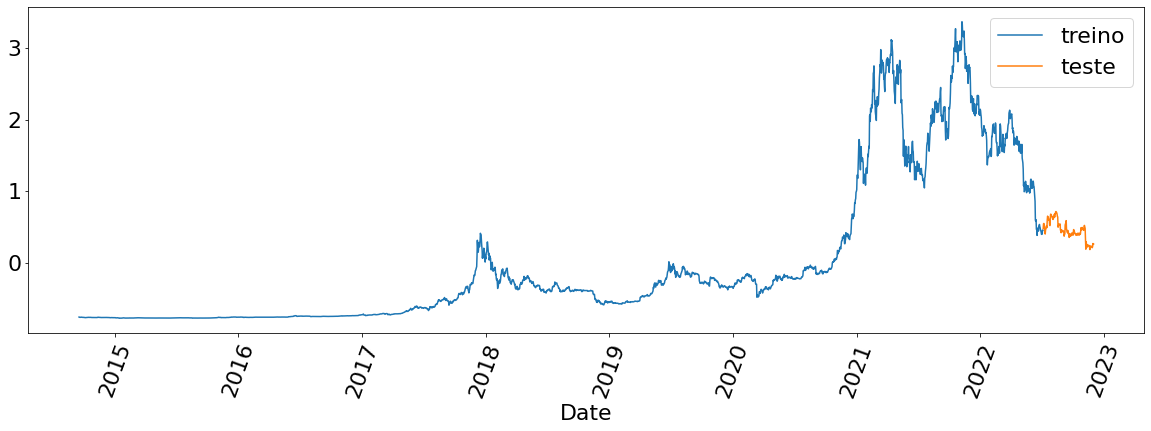

In [21]:
sns.lineplot(x='Date',y=train[:,0],data=df_btc_usd[0:train_size],label='treino') 
sns.lineplot(x='Date',y=test[:,0], data=df_btc_usd[train_size:len(df_btc_usd)],label='teste')
plt.xticks(rotation=70) 

#Dividindo em treino e teste

#Modelo LSTM

In [30]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [24]:
scaler = StandardScaler()

redimensionar a base de dados, com valores entre 0 e 1, sendo esta uma das exigências que o software LSTM possui para poder ser utilizado. Além disto, é necessário aplicar um reshape(-1,1) pois inicialmente o vetor é unidimensional, ao executar esta função, a entrada passa a ter duas dimensões, que é a entrada esperada pelo modelo LSTM. 

In [25]:
scaler.fit(df_btc_usd['Close'].values.reshape(-1,1))
scaled_data = scaler.transform(df_btc_usd['Close'].values.reshape(-1,1))

In [26]:
X_train = scaled_data[0:len(scaled_data)-1]
y_train = scaled_data[1:len(scaled_data)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [210]:
time_intervals_to_train = 7
prediction_interval = 30

In [216]:
def separa_dados(vetor,n_step):
  """Entrada: vetor: número de passageiros
               n_passos: número de passos no regressor
     Saída:
              trainX: Array 2D 
              trainY: Array 1D - Nosso alvo
  """
  trainX, trainY = [], []
  for i in range(n_step,vetor.shape[0]):
    trainX.append(list(vetor.loc[i-n_step:i-1]))
    trainY.append(vetor.loc[i])
  trainX, trainY = np.array(trainX), np.array(trainY) 
  return trainX, trainY

In [217]:
trainX, trainY = separa_dados(scaled_data,10)

AttributeError: ignored

In [41]:
model = Sequential()

In [42]:
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [43]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
history = model.fit(X_train, y_train, validation_data=(X_train,y_train), epochs=100, batch_size=50, verbose=2)

Epoch 1/100
60/60 - 2s - loss: 0.9582 - val_loss: 0.7685 - 2s/epoch - 31ms/step
Epoch 2/100
60/60 - 0s - loss: 0.6896 - val_loss: 0.5366 - 353ms/epoch - 6ms/step
Epoch 3/100
60/60 - 0s - loss: 0.4571 - val_loss: 0.3060 - 354ms/epoch - 6ms/step
Epoch 4/100
60/60 - 0s - loss: 0.2664 - val_loss: 0.1293 - 397ms/epoch - 7ms/step
Epoch 5/100
60/60 - 0s - loss: 0.1441 - val_loss: 0.0400 - 429ms/epoch - 7ms/step
Epoch 6/100
60/60 - 0s - loss: 0.0922 - val_loss: 0.0117 - 401ms/epoch - 7ms/step
Epoch 7/100
60/60 - 0s - loss: 0.0792 - val_loss: 0.0056 - 373ms/epoch - 6ms/step
Epoch 8/100
60/60 - 0s - loss: 0.0739 - val_loss: 0.0044 - 358ms/epoch - 6ms/step
Epoch 9/100
60/60 - 0s - loss: 0.0708 - val_loss: 0.0047 - 368ms/epoch - 6ms/step
Epoch 10/100
60/60 - 0s - loss: 0.0708 - val_loss: 0.0040 - 388ms/epoch - 6ms/step
Epoch 11/100
60/60 - 0s - loss: 0.0670 - val_loss: 0.0039 - 351ms/epoch - 6ms/step
Epoch 12/100
60/60 - 0s - loss: 0.0621 - val_loss: 0.0041 - 371ms/epoch - 6ms/step
Epoch 13/100
60

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [45]:
y_ajustado = model.predict(X_train)

94/94 [==============================] - 0s 2ms/step


In [ ]:
sns.lineplot(x='datas',y=y_train[:,0],data=bike[0:tamanho_treino],label='treino')
sns.lineplot(x='datas',y=y_ajustado[:,0],data=bike[0:15662],label='ajuste_treino')
plt.xticks(rotation=70) 

In [ ]:
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mean_squared_error',optimizer='RMSProp')

In [ ]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size =100, verbose =1 , shuffle = False)

In [ ]:
vetor = pd.DataFrame(ytreino)[0]

In [ ]:
xtreino_novo, ytreino_novo = separa_dados(vetor,10)

In [ ]:
xtreino_novo[0:5]

array([[-0.76067854, -0.76270208, -0.76452568, -0.7636578 , -0.76427808,
        -0.76407316, -0.7620038 , -0.76277805, -0.76349355, -0.76393334],
       [-0.76270208, -0.76452568, -0.7636578 , -0.76427808, -0.76407316,
        -0.7620038 , -0.76277805, -0.76349355, -0.76393334, -0.76423508],
       [-0.76452568, -0.7636578 , -0.76427808, -0.76407316, -0.7620038 ,
        -0.76277805, -0.76349355, -0.76393334, -0.76423508, -0.7656093 ],
       [-0.7636578 , -0.76427808, -0.76407316, -0.7620038 , -0.76277805,
        -0.76349355, -0.76393334, -0.76423508, -0.7656093 , -0.76571474],
       [-0.76427808, -0.76407316, -0.7620038 , -0.76277805, -0.76349355,
        -0.76393334, -0.76423508, -0.7656093 , -0.76571474, -0.76500871]])

In [ ]:
ytreino_novo[0:5]

array([-0.76423508, -0.7656093 , -0.76571474, -0.76500871, -0.7652135 ])

In [ ]:
vetor2 = pd.DataFrame(yteste)[0]

In [ ]:
xteste_novo, yteste_novo = separa_dados(vetor2,10)

## O que a LSTM espera

A entrada de redes recorrentes deve possuir a seguinte forma para a entrada (número de amostras, número de passos no tempo, e número de atributos por passo no tempo).

In [ ]:
xtreino_novo = xtreino_novo.reshape((xtreino_novo.shape[0],xtreino_novo.shape[1],1))

In [ ]:
xtreino_novo.shape

(2689, 10, 1)

In [ ]:
xteste_novo = xteste_novo.reshape((xteste_novo.shape[0],xteste_novo.shape[1],1))

## Usando a LSTM

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU

In [164]:
recorrente_g = Sequential()

In [165]:
recorrente_g.add(GRU(128, input_shape=(xtreino_novo.shape[1],xtreino_novo.shape[2])
                    ))
recorrente_g.add(Dense(units=1))

IndexError: ignored

In [ ]:
recorrente_g.compile(loss='mean_squared_error',optimizer='RMSProp')
recorrente_g.summary()

In [ ]:
resultado2 = recorrente_g.fit(xtreino_novo,ytreino_novo,
                              validation_data=(xteste_novo,yteste_novo),epochs=100)

In [ ]:
y_predito2 = recorrente_g.predict(xteste_novo)

In [ ]:
sns.lineplot(x='Date',y=yteste[:,0], data=df_preco_btc[tamanho_treino:len(df_preco_btc)])
sns.lineplot(x='Date',y=y_predito2[:,0], data=df_preco_btc[tamanho_treino+10:len(df_preco_btc)],marker='.')
plt.legend(['conhecido','estimado'])
plt.xticks(rotation=70) 

In [ ]:
plt.plot(resultado2.history['loss'])
plt.plot(resultado2.history['val_loss'])
plt.legend(['treino','teste'])


In [7]:
#from datetime import datetime, timedelta

import plotly.graph_objects as go

CRYPTO = 'BTC'
CURRENCY = 'USD'

crypto_data = df_btc_usd
fig = go.Figure(
        data = [
            go.Candlestick(
                x = crypto_data.Date,
                open = crypto_data.Open,
                high = crypto_data.High,
                low = crypto_data.Low,
                close = crypto_data.Close
            ),
           # go.Scatter(
           #     x = crypto_data.Date, 
           #     y = crypto_data.Close.rolling(window=20).mean(),
           #     mode = 'lines', 
           #     name = '20SMA',
           #     line = {'color': '#ff006a'}
            #),
            #go.Scatter(
            #    x = crypto_data.Date, 
            #    y = crypto_data.Close.rolling(window=50).mean(),
            #    mode = 'lines', 
            #    name = '50SMA',
            #    line = {'color': '#1900ff'}
            #)
        ]
    )
fig.update_layout(
    title = f'The Candlestick graph for {CRYPTO}',
    xaxis_title = 'Date',
    yaxis_title = f'Price ({CURRENCY})',
    xaxis_rangeslider_visible = False
)
fig.update_yaxes(tickprefix='$')

fig.show()